# Hydroroot model

TODO
=====
  - plot with groupby
  - R conversion for analysis
  - aquaporin expression modify the radial conductivity (k0 has a csv file)
  - running the notebook on a set of parameters
    - define functions
    - create a new notebook to run it and save the results
  - design the virtual experiment

Definition of the prameters

In [8]:
%matplotlib inline
%gui qt

Architectural parameters
------------------------
  - $n$ : number of nodes in primary root 
  - $\delta$: reference distance between successive branching axis
  - $\beta$ : branching variability or Number of nodes between successive ramification
  - $order_{max}$ : maximum order of ramification
  - $\lambda$ : nude tip length
  - $radius$ : external radius of the main axis of the root
  - $\alpha$ : order decrease factor : $r_{order} = radius*{\alpha}^{order}$

In [9]:
primary_length = 0.15
n = 1500
delta = 20
beta = 0.25 # 25 %
order_max = 5
segment_length = 1e-4
nude_length = 200
seed = 2

ref_radius = 1e-4 # in m
order_decrease_factor = 0.7

Conductance and model Parameters
=================================

  - $k_0$: radial conductivity
  - $K$ :axial conductivity (computed from xylem vessels)
  - $J_v$: Observed or calculated flow t the root base (hypocotyl)
  - $\psi_e$: external solution water potential 
  - $\psi_{base}$ : water potential at the hypocotyl
  
  

In [10]:
# parameters
k0 = 300
Jv = 0.1
psi_e = 0.4
psi_base = 0.1

### Define a length law that describe the length of ramification along the axis lentgh

In [11]:
from openalea.core.path import path
import hydroroot_wralea
import hydroroot
from hydroroot.length import fit_length
reload(hydroroot.length)
from hydroroot import radius, markov, flux, conductance, display as hdisplay
reload(markov)
from openalea.plantgl.all import Viewer

In [12]:
data_dir = path(hydroroot_wralea.__path__[0])/'data'
length_datafile, = data_dir.glob('LR_*.csv')
print length_datafile
#%load $length_datafile

C:\Python27\lib\site-packages\vplants.hydroroot-1.0.0-py2.7.egg\hydroroot_wralea\data\LR_length_data.csv


In [13]:
length_law = fit_length(str(length_datafile), segment_length)

Compute the architecture from these parameters
----------------------------------------------

In [14]:
g = markov.markov_binary_tree(nb_vertices=n,
                              branching_variability=beta,
                              branching_delay=delta,
                              length_law=length_law,
                              nude_tip_length=nude_length,
                              order_max=order_max,
                              seed=seed)
#print len(g)

In [8]:
# compute radius property on MTG
g = radius.ordered_radius(g, ref_radius=ref_radius, order_decrease_factor=order_decrease_factor)

# compute length property
g = radius.compute_length(g, segment_length)
g = radius.compute_relative_position(g)

In [15]:
# Shuffle axis
SHUFFLE = False
markov.shuffle_axis(g, SHUFFLE)

In [16]:
g, surface = radius.compute_surface(g)
g, volume = radius.compute_volume(g)

print 'Surface : ', surface
print 'Volume : ', volume

Surface :  0.0126756224791
Volume :  2.81737453689e-07


## Compute Flux

C:\Python27\lib\site-packages\vplants.hydroroot-1.0.0-py2.7.egg\hydroroot_wralea\data\conductivity_data.csv


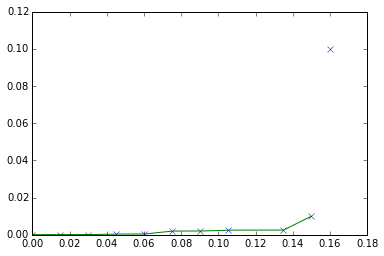

In [24]:
# axial conductance distribution
axial_data, = data_dir.glob('conductivity_data*.csv')
print axial_data

g = conductance.fit_property_from_csv(g, str(axial_data), 'position', 'K', k=1., s=0., plot=True) 

In [19]:
# %load C:\Python27\lib\site-packages\vplants.hydroroot-1.0.0-py2.7.egg\hydroroot_wralea\data\conductivity_data.csv




In [20]:
g = conductance.compute_k(g, k0)

In [21]:
g = flux.flux(g, Jv, psi_e, psi_base, invert_model=True)

In [22]:
# root visitor
def root_visitor(g, v, turtle):
    angles = [130,45]+[30]*5
    n = g.node(v)
    radius = n.radius*1.e4
    order = n.order
    length = n.length*1.e4

    if g.edge_type(v) == '+':
        angle = angles[order]
        turtle.down(angle)


    turtle.setId(v)
    turtle.setWidth(radius)
    for c in n.children():
        if c.edge_type() == '+':
            turtle.rollL(130)

    turtle.F(length)


In [23]:
scene = hdisplay.plot(g, has_radius=True, visitor=root_visitor, prop_cmap='psi_out', lognorm=False)
Viewer.display(scene)

> Everything below is for test only

In [ ]:
from vpltkdisplay import *
from IPython.display import display

In [ ]:
PlantGL(scene)

> Refactoring the model into a function

In [1]:
# meter

length_law = [0., 0.03, 0.05, 0.16], [0., 0., 0.01, 0.13]
axial_conductance_law = (
    [0., 0.015, 0.03, 0.045, 0.06, 0.075, 0.09, 0.105, 0.135, 0.15, 0.16], 
    [1e-4, 1e-4, 1e-4, 4e-4, 4e-4, 2e-3, 2e-3, 2.5e-3, 2.5e-3, 1e-2, 1e-1])
radial_conductance_law = (
    [0., 0.015, 0.03, 0.045, 0.06, 0.075, 0.09, 0.105, 0.135, 0.15, 0.16], 
    [300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300])



In [3]:
from hydroroot.main import hydroroot as hydro

g, surface, volume, Keq, Jv_global = hydro(
    length_data=length_law, 
    axial_conductance_data=axial_conductance_law, 
    radial_conductance_data=radial_conductance_law)

print surface, volume,
print Keq, Jv_global

entering MTG building
exiting MTG building
entering MTG radius setting
exiting MTG radius setting
entering MTG length setting
exiting MTG length setting
entering MTG node positionning computation
exiting MTG node positionning computation
entering surface computation
surface (sq. meters):  0.0126756224791
leaving surface computation
entering volume computation
volume (cube meters):  2.81737453689e-07
leaving volume computation
entering Keq computation
exiting Keq computation
entering Psi computation
exiting Psi computation
entering Jv computation
exiting Jv computation
Keq base =  0.347049173524
Local Computation Water Flux Jvl =  0.104114752057
Global Computation Water Flux Jvg =  0.104114752057
0.0126756224791 2.81737453689e-07 0.347049173524 0.104114752057
